### Importing dependencies

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
import contractions
import unicodedata
import spacy
from sklearn import metrics

%matplotlib inline

In [11]:
df_train = pd.read_csv('train-dataset.csv')
df_test = pd.read_csv('hold-out.csv')

In [8]:
df_train.head()

,comment,offensive,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,nonsense kiss geek say true account terminate,1,1,0,0,0,0,0
1,please not vandalize page edit w merwin contin...,0,0,0,0,0,0,0
2,point interest remove point interest section a...,0,0,0,0,0,0,0
3,ask nationality racial offence wow not aware b...,0,0,0,0,0,0,0
4,reader not go say ethereal vocal style dark ly...,0,0,0,0,0,0,0


In [28]:
df_test.head()

,comment,offensive,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,revert constitute vandalism revert please not ...,0,0,0,0,0,0,0
1,call someone petty tyrant personal attack kind...,0,0,0,0,0,0,0
2,article manage become ga thank work hope use e...,0,0,0,0,0,0,0
3,hey mr troll not learn word vandalism mean bet...,1,1,0,1,0,0,0
4,miscellaneous section look like basically list...,0,0,0,0,0,0,0


In [14]:
df_test.isnull().sum()

comment          9
offensive        0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [27]:
df_test = df_test[~(df_test['comment'].isnull())]

### Load and View Dataset

In [47]:
X_train = df_train['comment']
X_test = df_test['comment'][:10000]

y_train = df_train['offensive']
y_test = df_test['offensive'][:10000]

### Feature Engineering with word embeddings

In [299]:
%%time

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(binary=False, min_df=5, max_df=1.0)

vect_train_matrix = vect.fit_transform(X_train)
vect_test_matrix = vect.transform(X_test)

CPU times: user 960 ms, sys: 316 ms, total: 1.28 s
Wall time: 1.81 s


In [33]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0)

tfid_train_matrix = tfid.fit_transform(X_train)
tfid_test_matrix = tfid.transform(X_test)

CPU times: user 875 ms, sys: 22.7 ms, total: 898 ms
Wall time: 897 ms


In [87]:
print("Bag of words training dataset 1-gram features" , vect_train_matrix.shape[1])
print("Bag of words test dataset 1-gram features" , vect_test_matrix.shape[1])

print ("Tfidf training dataset 1-gram features" , tfid_train_matrix.shape[1])
print ("Tfidd of words training dataset 1-gram features" , tfid_train_matrix.shape[1])

Bag of words training dataset 1-gram features 7809
Bag of words test dataset 1-gram features 7809
Tfidf training dataset 1-gram features 7809
Tfidd of words training dataset 1-gram features 7809


### Training Logistic Regression Model

Before we start training the models we need to identify our main evaluation metrics. **Our goal here is to label the offensive comments correctly.** So, this model requires the **least possible False Negative labels** and checking accuracy by itself is not enoguh to evaluate the performance of the model. In addition to accuracy we need to evaluate the rate of False Negatives by checking **Recall.**  

In [300]:
%%time

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs')

lr.fit(vect_train_matrix, y_train)

lr_bow_prediction = lr.predict(vect_test_matrix)

CPU times: user 2.29 s, sys: 99.5 ms, total: 2.39 s
Wall time: 718 ms


In [301]:
print (metrics.accuracy_score(y_test , lr_bow_prediction))

print (metrics.confusion_matrix(y_test , lr_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

0.9486
[[8886  103]
 [ 411  600]]
F1 score:  0.7001166861143523
Precision score:  0.8534850640113798
Recall score:  0.5934718100890207


In [229]:
%%time

lr.fit(tfid_train_matrix, y_train)

lr_tfid_prediction = lr.predict(tfid_test_matrix)

print (metrics.accuracy_score(y_test , lr_tfid_prediction))

print (metrics.confusion_matrix(y_test , lr_tfid_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_tfid_prediction))

print("Precision score: " , metrics.precision_score(y_test , lr_tfid_prediction))

print("Recall score: " , metrics.recall_score(y_test , lr_tfid_prediction))

0.9431
[[8970   19]
 [ 550  461]]
F1 score:  0.6183769282360831
Precision score:  0.9604166666666667
Recall score:  0.4559841740850643
CPU times: user 887 ms, sys: 20.5 ms, total: 908 ms
Wall time: 261 ms


### Comparing performance of Logistic Regression with Bag of Words and Tf-idf shows Bag of Words performs better with Logistice Regression. Continuing optimizing of Logistic Regression with Bag of words. 

In [231]:
%%time

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= .5) , lr)

smote_model = smote_pipeline.fit(vect_train_matrix , y_train)

smote_predict = smote_model.predict(vect_test_matrix)

print (metrics.accuracy_score(y_test , smote_predict))

print (metrics.confusion_matrix(y_test , smote_predict))

print("F1 score: ", metrics.f1_score(y_test , smote_predict))

print("Precision score: " , metrics.precision_score(y_test , smote_predict))

print("Recall score: " , metrics.recall_score(y_test , smote_predict))

0.8966
[[8234  755]
 [ 279  732]]
F1 score:  0.5860688550840673
Precision score:  0.49226630800269
Recall score:  0.7240356083086054
CPU times: user 7.37 s, sys: 59.6 ms, total: 7.43 s
Wall time: 3.87 s


### Imbalance datasets can lead to false predictions and false sense of accuracy. One of the approaches to balance the classes is by increasing the minority or decreasing the majority samples in our model. Here we chose to oversample the class 1 or offensive comments via  SMOTE. As you see we have a significant improvement on Recall and number of False Negative labels. 

### Training Random Forest Model

In [228]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

rfc_bow_pipe = make_pipeline(vect , rfc)

rfc_bow_pipe.fit(X_train , y_train)

rfc_bow_prediction = rfc_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , rfc_bow_prediction))

print (metrics.confusion_matrix(y_test , rfc_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , rfc_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , rfc_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , rfc_bow_prediction))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9485
[[8878  111]
 [ 404  607]]
F1 score:  0.70213996529786
Precision score:  0.8454038997214485
Recall score:  0.6003956478733927


### Hyper-parameter tuning to optimize Random Forest through Randoomized Search

In [111]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [113]:
%%time

from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(rfc , param_grid , n_iter = 3 , cv = 3)

random.fit(vect_train_matrix , y_train)

CPU times: user 4min 43s, sys: 859 ms, total: 4min 44s
Wall time: 4min 45s


In [115]:
random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [215]:
%%time

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)


rfc_bow_pipe = make_pipeline(vect , rfc)

rfc_bow_pipe.fit(X_train , y_train)

rfc_bow_prediction = rfc_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , rfc_bow_prediction))

print (metrics.confusion_matrix(y_test , rfc_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , rfc_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , rfc_bow_prediction))

print ("Recall score: " , metrics.recall_score(y_test , rfc_bow_prediction))

0.9495
[[8955   34]
 [ 471  540]]
F1 score:  0.6813880126182965
Precision score:  0.9407665505226481
Recall score:  0.5341246290801187
CPU times: user 49.5 s, sys: 202 ms, total: 49.7 s
Wall time: 49.8 s


In [227]:
%%time

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)


rfc_tfid_pipe = make_pipeline(tfid , rfc)

rfc_tfid_pipe.fit(X_train , y_train)

rfc_tfid_prediction = rfc_tfid_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , rfc_tfid_prediction))

print (metrics.confusion_matrix(y_test , rfc_tfid_prediction))

print("F1 score: ", metrics.f1_score(y_test , rfc_tfid_prediction))

print("Precision score: " , metrics.precision_score(y_test , rfc_tfid_prediction))

print("Recall score: " , metrics.recall_score(y_test , rfc_tfid_prediction))

0.9528
[[8930   59]
 [ 413  598]]
F1 score:  0.7170263788968825
Precision score:  0.9101978691019786
Recall score:  0.5914935707220573
CPU times: user 1min 11s, sys: 173 ms, total: 1min 11s
Wall time: 1min 11s


### Tuned Random Forest model works better with Tf-idf. Yet, in the best case it dooesn't out perform Logistic Regression. 

### Training Naïve Bayes Model

In [197]:
import scipy as sp

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb_bow_pipe = make_pipeline(vect , nb)

param_grid= {
    'multinomialnb__alpha' : sp.stats.uniform(scale = 1)
}

nb_bow_pipe = make_pipeline(vect , nb)

random = RandomizedSearchCV(nb_bow_pipe , param_grid , cv = 5 , scoring = 'f1')

random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), p..., vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a482872b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [198]:
random.best_score_

0.7154603178966132

In [199]:
random.best_params_

{'multinomialnb__alpha': 0.7017405572309684}

In [226]:
nb = MultinomialNB(alpha= 0.701)

nb_bow_pipe = make_pipeline(vect , nb)

nb_bow_pipe.fit(X_train , y_train)

nb_bow_predction = nb_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , nb_bow_predction))

print (metrics.confusion_matrix(y_test , nb_bow_predction))

print("F1 score: ", metrics.f1_score(y_test , nb_bow_predction))

print("Precision score: " , metrics.precision_score(y_test , nb_bow_predction))

print("Recall score: " , metrics.recall_score(y_test , nb_bow_predction))

0.9446
[[8767  222]
 [ 332  679]]
F1 score:  0.7102510460251047
Precision score:  0.753607103218646
Recall score:  0.6716122650840751


### Optimized Naïve Bayes with alpha = 0.715 works better than Random Forest, still doesnt out perform Logistic Regression. 

### Training XGBoost

In [223]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.01,n_estimators=200 )

xgb_bow_pipe = make_pipeline(vect , xgb)

xgb_bow_pipe.fit(X_train , y_train)

xgb_bow_prediction = xgb_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , xgb_bow_prediction))

print (metrics.confusion_matrix(y_test , xgb_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , xgb_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , xgb_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , xgb_bow_prediction))

0.9233
[[8979   10]
 [ 757  254]]
F1 score:  0.3984313725490196
Precision score:  0.9621212121212122
Recall score:  0.2512363996043521


### Without hyper-parameter tuning, model performs poorly. We have very high number of False Negative. 

### Hyper-parameter tuning to optimize XGBoost through Randoomized Search

P.S: The run time was unexpectedly high, so I decided to split the process into smaller steps, as each step performs tunnign on one parameter. 

In [302]:
param_grid = {"xgbclassifier__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "xgbclassifier__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ],
 "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [217]:
%%time

param_grid = {
    "xgbclassifier__learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 }

xgb = XGBClassifier()

xgb_bow_pipe = make_pipeline(vect , xgb)

grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'recall')

grid.fit(X_train , y_train)

CPU times: user 2min 23s, sys: 548 ms, total: 2min 24s
Wall time: 2min 24s


In [218]:
grid.best_params_

{'xgbclassifier__learning_rate': 0.3}

In [219]:
param_grid = {
 "xgbclassifier__max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15] }

xgb = XGBClassifier(learning_rate=0.3)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'recall')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__max_depth': [3, 4, 5, 6, 8, 10, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [220]:
grid.best_score_

0.5215555840110736

In [221]:
grid.best_params_

{'xgbclassifier__max_depth': 15}

In [183]:
param_grid = {
    "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ]}

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'f1')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__min_child_weight': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [184]:
grid.score

0.5762104722959444

In [185]:
param_grid = {
 "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ] }

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'f1')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [186]:
grid.best_score_

0.5700055338712294

In [187]:
param_grid = {
 "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'recall')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [188]:
grid.best_score_

0.5656195544254697

In [216]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

xgb_tfid_pipe = make_pipeline(tfid , xgb)

xgb_tfid_pipe.fit(X_train , y_train)

xgb_tfid_prediction = xgb_tfid_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , xgb_tfid_prediction))

print (metrics.confusion_matrix(y_test , xgb_tfid_prediction))

print("F1 score: ", metrics.f1_score(y_test , xgb_tfid_prediction))

print("Precision score: " , metrics.precision_score(y_test , xgb_tfid_prediction))

print ("Recall score: ", metrics.recall_score(y_test , xgb_tfid_prediction))

0.9537
[[8915   74]
 [ 389  622]]
F1 score:  0.7287639132981838
Precision score:  0.8936781609195402
Recall score:  0.6152324431256182


In [213]:
xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

xgb_bow_pipe = make_pipeline(vect , xgb)

xgb_bow_pipe.fit(X_train , y_train)

xgb_bow_prediction = xgb_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , xgb_bow_prediction))

print (metrics.confusion_matrix(y_test , xgb_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , xgb_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , xgb_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , xgb_bow_prediction))

0.9518
[[8889  100]
 [ 382  629]]
F1 score:  0.7229885057471263
Precision score:  0.8628257887517147
Recall score:  0.6221562809099901


### We see a great improvement after tunning 3 parameters "learning_rate", "max_depth" and "n_estimators". However, model still doesn't out perform Logistic Regression. 

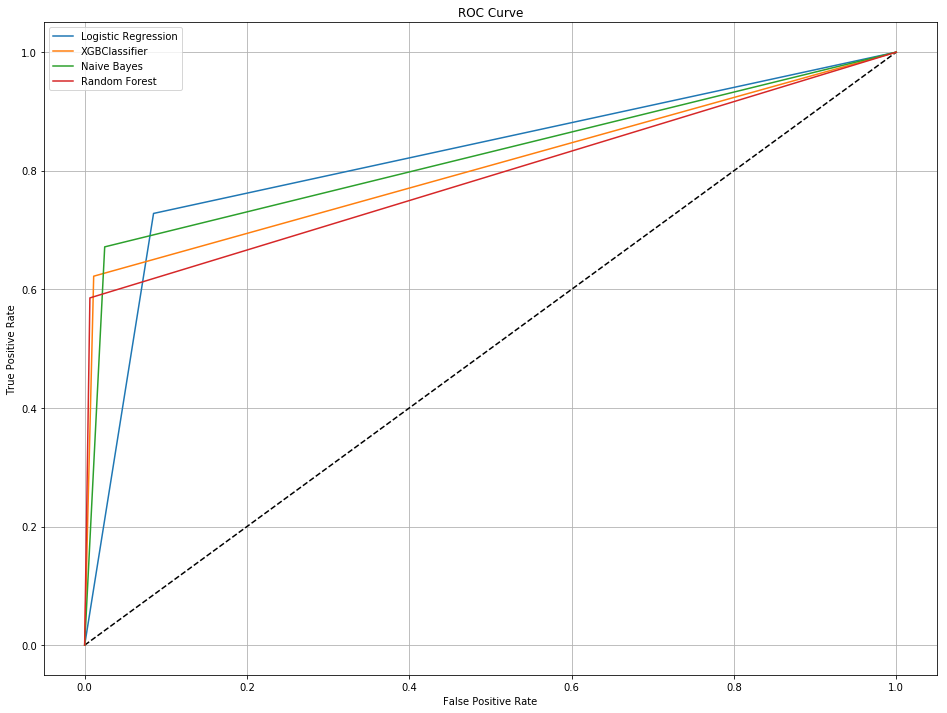

In [211]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_fp, lr_tpr, lr_thresholds  = roc_curve(y_test, smote_predict)
svm_fp, svm_tpr, svm_thresholds  = roc_curve(y_test, xgb_bow_prediction)
nb_fp, nb_tpr, nb_thresholds  = roc_curve(y_test, nb_bow_predction)
rf_fp, rf_tpr, rf_thresholds  = roc_curve(y_test, rfc_tfid_prediction)
plt.figure(figsize= (16 , 12))
plt.plot([0,1], [0,1], 'k--' , )
plt.plot(lr_fp, lr_tpr, label='Logistic Regression')
plt.plot(svm_fp, svm_tpr, label='XGBClassifier')
plt.plot(nb_fp, nb_tpr, label='Naive Bayes')
plt.plot(rf_fp, rf_tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.show()

In [305]:
lr = roc_auc_score(y_test, smote_predict) 
xgb = roc_auc_score(y_test, xgb_bow_prediction)
nb = roc_auc_score(y_test, nb_bow_predction)
rfc = roc_auc_score(y_test, rfc_tfid_prediction)

In [307]:
import cufflinks as cf
import plotly
plotly.tools.set_credentials_file(username='nehrmegar', api_key='Ssb3HL4agEFKnGpftCV8')
import plotly.graph_objs as go
import plotly.plotly as py

data = [go.Bar(
            x=['Logistic Regression', 'XGBClassifier', 'Naive Bayes', 'Random Forest'],
            y=[lr, xgb, nb, rfc]
    )]

py.iplot(data, filename='basic-bar')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [308]:
lr_recall = metrics.recall_score(y_test, smote_predict) 
xgb_recall = metrics.recall_score(y_test, xgb_bow_prediction)
nb_recall = metrics.recall_score(y_test, nb_bow_predction)
rfc_recall = metrics.recall_score(y_test, rfc_tfid_prediction)

In [315]:
data = [go.Bar(
            x=['Logistic Regression', 'XGBClassifier', 'Naive Bayes', 'Random Forest'],
            y=[lr_recall, xgb_recall, nb_recall, rfc_recall]
    )]

layout = go.Layout(
    title = "Comparing Recall Values" )
fig = go.Figure(data=data,layout=layout )
py.iplot(fig )

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead




### Even Though Naïve Bayes has a slightly higher auc, but the key indicator of performance for us in this case is the number of False Negatives and the best result is from Logistic Regression - SMOTE with 0.90% accuracy and 279 False Negative predictions. 

### Logistic Regression - SMOTE with bag of words
#### Accuracy : 0.8966
#### Confusion Matrix: 
#### [[8234  755]
#### [ 279  732]]
#### F1 score:  0.5860688550840673
#### Precision score:  0.49226630800269
#### Recall score:  0.7240356083086054
